##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [199]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from multiprocessing import Pool
from functools import partial
from sklearn import metrics

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
# from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats

from ipywidgets import FloatProgress, HTML
from IPython.display import display, clear_output
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

import json
import os


def Test(params,X,y,YScaled,XScaled,pool):
    return(np.random.rand(params['K']))


def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
        if Scope == 'Full':
            Model = ['PPFD_Avg','AirTC_Avg','VPD','wind_speed',
                    'Temp','VWC','Sedge','Shrub','Grass','Upland',
                    'HR','DOY']
        if Scope == 'Test':
            Model = ['PPFD_Avg','VPD','wind_speed','VWC']
    if Site == 'FishIsland':
        BaseFactors = []
#         Model  = [
#                 'AirTC_Avg','VPD','RH','NR_Wm2_Avg','PPFD_Avg',
#                 'Table_1','VWC_2','VWC_1','Active_Layer_1',
#                 'Temp_2_5_1','Temp_5_1','Temp_15_1',
#                 'Temp_2_5_2','Temp_5_2','Temp_15_2',
#                 'u*','wind_speed','air_pressure','Wind_Direction',
#                 'DOY','Time'
#                  ]  


        Model=['AirTC_Avg', 'VPD', 'NR_Wm2_Avg', 'PPFD_Avg', 'Table_1', 
               'VWC_2','VWC_1',
               'Active_Layer_1',
               'Temp_2_5_1', 'Temp_5_1', 'Temp_15_1', 
               'Temp_2_5_2',
               'Temp_5_2',
               'Temp_15_2', 
                'u*', 'wind_speed', 'air_pressure', 'Wind_Direction',
              'Time','DOY']
    
    
# #         if Scope == 'Full':
#         Model=['AirTC_Avg','VPD','NR_Wm2_Avg','PPFD_Avg',
#                'Table_1','VWC_2','DOY','Time',
#                'Temp_2_5_1','Temp_5_1','Temp_15_1','Temp_2_5_2','Temp_5_2',
#                'u*',#'Ratio',
#                'wind_speed','air_pressure','Wind_Direction',
#                'Rolling_Temp_15_1','Delta_Table_1','Delta_air_pressure']               
#         if Scope == 'Test':
#             Model=['AirTC_Avg','VPD','NR_Wm2_Avg','PPFD_Avg',
#                    'Table_1','VWC_2','Active_Layer_1','Hour','DOY',
#                    'Temp_2_5_1','Temp_5_1','Temp_15_1','Temp_2_5_2','Temp_5_2','Temp_15_2',
#                    'u*','wind_speed','air_pressure','Wind_Direction']  
#             Model=['AirTemp','Rainfall_Tot','SoilMoist(4)','SoilMoist(5)','Net_SW_Wm2_Avg',
#                    'Net_LW_Wm2_Avg','Net_Ttl_Rad_Avg','WindSpd','Delta_SoilMoist(4)','Delta_SoilMoist(5)']
    return(Model)

def Stats(mse,rmse,se,r2,j,params,i=0):
    df = pd.DataFrame(index = [str(j)+'_'+str(i)],#params['N'])],
                      data={'Model':[params['Model']],'Size':j,'Nodes':params['N']
                            ,'MSE':[mse],'RMSE':[rmse],'SE':[se],'r2':[r2],
                            'Performance':0,'K':[params['K']]})
    return(df)

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))
MP = False
MP = True

Scope = 'Full'
# Scope = 'Test'
# Scope = 'Single'
if MP == True:
    processes = 3
else:
    processes = 1
# memory = .95/processes
    
cwd = os.getcwd()
Site='FishIsland'
# Site = 'Illisarvik'
alpha = .05

pd.set_option('max_colwidth',200)
def Display (tar,prog1=None,prog2=None,MdLs=None,MdL=None):
    clear_output()
    display(tar)
    if prog1!=None:
        display(prog1)
    if prog2!=None:
        display(prog2)
    if MdLs!=None:
        display(MdLs)
    if MdL!=None:
        display(MdL)
    
tar = HTML(
            value=" ",
            placeholder='Target: ',
            description='Target: ',
        )
kwt = HTML(
        value=str(0),
        placeholder='Quit Score: ',
        description='Quit Score: ',
        )


Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'   
# try:
#     shutil.rmtree(Path)
# except:
#     pass
try:
    os.mkdir(Path+'/')
except:
    pass
# print(Path)

In [200]:
def RecWrite(AllRes,Path):
    for f in AllRes.keys():
        try:
            os.mkdir(Path)
        except:
            pass
        for t in AllRes[f].keys():
            if t != 'Results' and t != 'Records' and t!= 'Removed':
                for p in AllRes[f][t].keys():
                    if t == 'X':
                        np.save(Path+f+'_'+t+'_'+str(p)+'.npy',AllRes[f][t][p][0])
                        
                    else:
                        for p2 in AllRes[f][t][p].keys():
                            np.save(Path+f+'_'+t+'_'+str(p)+'_'+str(p2)+'.npy',AllRes[f][t][p][p2])
        AllRes[f]['Records'].to_csv(Path+f+'_Runs.csv')
        AllRes[f]['Results'].to_csv(Path+f+'_Results.csv')
#         file=open(Path+f+'_Removed.txt','w')
#         s1=','.join(AllRes[f]['Removed'])
#         file.write(s1)
#         file.close()
        
def RecRead(Path):
    AllRes={}
    for f in ['fco2','fch4','ER']:
        try:
            AllRes[f]={}
            AllRes[f]['Records']=pd.read_csv(Path+f+'_Runs.csv',index_col=0)
            AllRes[f]['Results']=pd.read_csv(Path+f+'_Results.csv',index_col=0)
    #         temp=open(Path+f+'_Removed.txt', "r")
    #         AllRes[f]['Removed'] = temp.read().split(',')
            AllRes[f]['Derivatives']={}
            AllRes[f]['SSQ'] ={}
            AllRes[f]['X'] = {}
            AllRes[f]['Yhat'] = {}
            AllRes[f]['Ytrue'] = {}
            AllRes[f]['Outputs'] = {}
        except:
            pass
#         for filename in os.listdir(Path):
#             if filename.endswith(".npy") and filename.split('.')[0].split('_')[0]==f:
# #                 print(filename)
#                 AllRes[f][filename.split('.')[0].split('_')[1]][int(filename.split('.')[0].split('_')[2])]={}
#                 AllRes[f][filename.split('.')[0].split('_')[1]][int(filename.split('.')[0].split('_')[2])]\
#                 [int(filename.split('.')[0].split('_')[-1])]=np.load(Path+filename)
    return(AllRes)

# SE_Rule = 1

In [201]:
# depth = 15
SE_Rule=1.96#00
SE_Rule = 1
Time = time.time()
AllRes={}
if __name__ == '__main__':
#     try:
#         shutil.rmtree(Path+'/'+target+'/')
#         os.mkdir(Path+'/')
#     except:pass
    for target in ['fco2','fch4']:#,'
        try:
            shutil.rmtree(Path+'/'+target+'/')
        except:
            pass
        try:
            os.mkdir(Path+'/'+target+'/')
        except:
            pass
        AllRes[target]={}
#         AllRes[target]['Results'] = {}
        AllRes[target]['Derivatives'] = {}
        AllRes[target]['SSQ'] ={}
        AllRes[target]['X'] = {}
        AllRes[target]['Yhat'] = {}
        AllRes[target]['Ytrue'] = {}
        AllRes[target]['Outputs'] = {}
#         AllRes[target]['Removed']={}
#         AllRes[target]['Factors'] = []
        Rm = []
        Input=ModSelect(Scope,Site)
        
        
        start = len(Input)
        IpKey=np.arange(0,start)
        IpDict={'Factors':Input.copy(),'Key':IpKey}
#         try:
#             shutil.rmtree(Path+'/'+target+'/')
#         os.mkdir(Path+'/'+target+'/')  
#         except:pass
        tar.value=target
        prog2 = FloatProgress(min=0, max=100,description='Bootstrapping:')
        MdL = HTML(value=" ",placeholder='Testing: ',description='Testing: ')
#         Display (tar,prog2=prog2,MdL=MdL)
        Continue = True
        first = 1
        run = 1
        num = 0
        while len(Input)>0 and run == 1:
#         while run < 3:
#             for num in [30]:
            j = len(Input)
            AllRes[target]['Derivatives'][j] = {}
            AllRes[target]['SSQ'][j] ={}
            AllRes[target]['Yhat'][j] = {}
            AllRes[target]['Ytrue'][j] = {}
            AllRes[target]['Outputs'][j] = {}
#             for Input in [['PPFD_Avg','NR_Wm2_Avg'],['PPFD_Avg','Temp_5_1']]:

            for num in [100]:
#                 num += 1
                Time2 = time.time()
                params = Dense.Params(Scope,target,MP=MP)#,Act='sigmoid')
                params['Dpath'] = cwd+'/'+Site+'/'

                params['Inputs'] = Input
                MdL.value='N = '+str(j)+':  '+str(params['Inputs'])
                Display (tar,prog2=prog2,MdL=MdL)
                print('Inputs!: ', params['Inputs'])
                print('Total Runtime: ',time.time()-Time)
                print('Training Time: ', time.time()-Time2)
                params['Model'] = '+'.join(params['Inputs'])
                RST = RSTF.ReadStandardTimeFill(params,'AllData.csv')#,resample='H')
        #             RST = RSTF.ReadStandardTimeFill(params,'TagluData.csv')#,resample='2H')
                if target == 'ER':
                    RST.Master = RST.Master.loc[RST.Master['PPFD_Avg']<20]
                RST.Master['Night']=1
                RST.Master['Month']=RST.Master.index.month
                RST.Master.loc[RST.Master['PPFD_Avg']<10,'Night']=2
                RST.Master['Night'] *= RST.Master['Month']

                Ni = len(Input)
                Ns = int(RST.Master[target].count()*(1-params['validation_split']))
                No = 1
                a = 2
                
                num = int(Ns/(a*(Ni+No)))
                
                params['N'] = int(Ns/30)
                print('N: ',params['N'])
                num = params['N']
                
                
#                 num = params['N']
#                 params['N']=num

                params['Sname'] = 'Y_'
                params['Spath'] = Path+target+'/'+str(j)+'_'+str(num)+'/'
                os.mkdir(params['Spath'])
                RST.Scale(params['target'],params['Inputs']) 
                y = RST.y*1.0
                X = RST.X*1.0
    #             print(X,y)
    #             params['N']=2
    #             print(params['N'])
#                 Rule by Maier et al. 1998
                
#                 A = int(a*Ni+No)
#                 B = int(Ns/((Ni+No)))
#                 if A<B:params['N']=A
#                 else:params['N']=B

                params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
                Y_hat=[]
                y_true=[]
                X_true=[]
                index=[]
                ones=[]
                prog2.value=0
                Avs = []
                Derivatives = []
                Outputs=[]
                if MP == False:
                    for k in range(params['K']):
                        results = Dense.Bootstrap(k,params=params,X=X,y=y)
                        Y_hat.append(RST.YScaled.inverse_transform(results[0].reshape(-1,1)))
                        y_true.append(RST.YScaled.inverse_transform(results[1].reshape(-1,1)))
                        X_true.append(RST.XScaled.inverse_transform(results[2]))
                        ones.append(results[3])
                        prog2.value=(k+1)/params['K']*100
                        Avs.append(results[4])
                        Derivatives.append(results[5])
                        Outputs = results[6]
                else:
                    pool = Pool(processes=processes,maxtasksperchild=75)
                    for k,results in enumerate(pool.imap_unordered(partial(Dense.Bootstrap,params=params,X=X,y=y,
                                                                          Stratify=RST.Data.Night
                                                                          ),range(params['K']))):
                        Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                        y_true.append(RST.YScaled.inverse_transform(results[1]))
                        X_true.append(RST.XScaled.inverse_transform(results[2]))
                        ones.append(results[3])
                        prog2.value=(k+1)/params['K']*100
                        Avs.append(results[4])
                        Derivatives.append(results[5])
                        Outputs.append(results[6])
                    pool.close()
                Y_hat = np.squeeze(np.asanyarray(Y_hat))
                y_true = np.squeeze(np.asanyarray(y_true))
                X_true = np.asanyarray(X_true)
                ones = np.asanyarray(ones)
                params['Memory'] = .95
                results = Dense.Sort_outputs(0,params=params,Y_hat=Y_hat,y_true=y_true,X_true=X_true,ones=ones)
                mse,rmse,se,r2,Y_Val,Y_hat_Val = results
                Level = Stats(mse,rmse,se,r2,j,params,i=num)
                Level.to_csv('Temp.csv')
    #             prog1.value=start-j#+i/len(Inputs)
                Level['Thresh'] = Level['MSE']+Level['SE']
                Min = Level.loc[Level['MSE']==Level['MSE'].min()]
                if first == 1:
                    Records = Level
                else:
                    Records = Records.append(Level)
                Av = np.array(Avs).mean(axis=0)
#                 print(Av)
                Drv = np.array(Derivatives)#.mean(axis=0)
#                 Av = (Drv.mean(axis=0)**2).sum(axis=1)
#                 print(Av)
                Range = Drv.mean(axis=0).max(axis=1)-Drv.mean(axis=0).min(axis=1)
#                 SE = (np.array(Avs).T/np.array(Avs).sum(axis=1)).T
                SE = np.array(Avs).std(axis=0)**.5/(params['K']**.5)
                if first==2:
                    IpDict['RC_Sum: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])
                    IpDict['RC: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])
                    IpDict['RG: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])#Av/Av.sum()
                    IpDict['SE: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])#Av/Av.sum()
                    IpDict['CS: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])
                else:
                    first = 2
                Results = pd.DataFrame(data=IpDict)
                for I,A,S,R in zip(Input,Av,SE,Range):
                    Results.loc[Results['Factors']==I,'RC: '+str(j)+'_'+ str(num)]=A
                    Results.loc[Results['Factors']==I,'RG: '+str(j)+'_'+ str(num)]=R
                    Results.loc[Results['Factors']==I,'SE: '+str(j)+'_'+ str(num)]=S
                Results['RC_Sum: '+str(j)+'_'+ str(num)]=Results['RC: '+str(j)+'_'+ str(num)]/Results['RC: '+str(j)+'_'+ str(num)].sum()

                IpDict['RC_Sum: '+str(j)+'_'+ str(num)]=Results['RC_Sum: '+str(j)+'_'+ str(num)].values
                IpDict['RC: '+str(j)+'_'+ str(num)]=Results['RC: '+str(j)+'_'+ str(num)].values
                IpDict['RG: '+str(j)+'_'+ str(num)]=Results['RG: '+str(j)+'_'+ str(num)].values
                IpDict['SE: '+str(j)+'_'+ str(num)]=Results['SE: '+str(j)+'_'+ str(num)].values
                Results = Results.sort_values('RC: '+str(j)+'_'+ str(num))
                Resluts = Results.reset_index()
                Results['CS: '+str(j)+'_'+ str(num)]=Results['RC_Sum: '+str(j)+'_'+ str(num)].sort_values(ascending=False).cumsum().sort_values(ascending=False)
                Results = Results.sort_values('Key')
                IpDict['CS: '+str(j)+'_'+ str(num)]=Results['CS: '+str(j)+'_'+ str(num)].values
                Min = Records.loc[Records['MSE']==Records['MSE'].min()]
                AllRes[target]['Records'] = Records
                AllRes[target]['Results'] = Results
                AllRes[target]['Derivatives'][j][num] = Drv
                print(j,num)
                AllRes[target]['SSQ'][j][num] = Avs
                AllRes[target]['X'][j] = X_true
                AllRes[target]['Outputs'][j][num] = Outputs
                AllRes[target]['Yhat'][j][num] = Y_hat_Val
                AllRes[target]['Ytrue'][j][num] = Y_Val 
            
#             if run <= 1:
            Min = Records.loc[Records['MSE']==Records['MSE'].min()]
            Best = Records.loc[Records['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]*SE_Rule]
            Best = Best.loc[Best['Size']==Best['Size'].min()]  
            
#             Best = Records.loc[Records['SE']==Records['SE'].min()]
#             Best = Records.loc[Records['Size']==Records['Size'].min()]
            K = Best.index.values[0]
            run = 0
            
#             for k in Results.loc[((Results['CS: '+K]>.9)&(Results['RC: '+K]>0)),'Factors'].values:
            for k in Results.loc[(Results['RC_Sum: '+K]<.025),'Factors'].values:
#             Km = Results.loc[Results['RC: '+K]>0]
#             Km = Km.loc[Km['RC: '+K]==Km['RC: '+K].min(),'RC: '+K].values[0]
#             for k in Results.loc[(Results['RC: '+K]==Km),'Factors'].values:
                if k in Input:
                    print(k)
                    Input.remove(k)
                    run = 1
                    
RecWrite(AllRes,Path)

HTML(value='fch4', description='Target: ', placeholder='Target: ')

FloatProgress(value=100.0, description='Bootstrapping:')

HTML(value="N = 15:  ['AirTC_Avg', 'NR_Wm2_Avg', 'PPFD_Avg', 'Table_1', 'VWC_2', 'Active_Layer_1', 'Temp_5_1',…

Inputs!:  ['AirTC_Avg', 'NR_Wm2_Avg', 'PPFD_Avg', 'Table_1', 'VWC_2', 'Active_Layer_1', 'Temp_5_1', 'Temp_15_1', 'Temp_5_2', 'Temp_15_2', 'u*', 'wind_speed', 'air_pressure', 'Wind_Direction', 'DOY']
Total Runtime:  906.7269155979156
Training Time:  0.02194046974182129
N:  39


C:\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:709: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


15 39


dict_keys(['fco2', 'fch4', 'ER'])
                                                                                                                                                                                     Model  \
20_59  AirTC_Avg+VPD+NR_Wm2_Avg+PPFD_Avg+Table_1+VWC_2+VWC_1+Active_Layer_1+Temp_2_5_1+Temp_5_1+Temp_15_1+Temp_2_5_2+Temp_5_2+Temp_15_2+u*+wind_speed+air_pressure+Wind_Direction+Time+DOY   
11_59                                                                                                        VPD+NR_Wm2_Avg+PPFD_Avg+Table_1+VWC_2+Temp_5_1+Temp_5_2+Temp_15_2+u*+Time+DOY   

       Size  Nodes       MSE      RMSE        SE        r2  Performance   K  \
20_59    20     59  0.156887  0.396089  0.003812  0.929826            0  30   
11_59    11     59  0.192354  0.438582  0.003950  0.913962            0  30   

         Thresh  
20_59  0.160699  
11_59  0.196304  


<IPython.core.display.Javascript object>


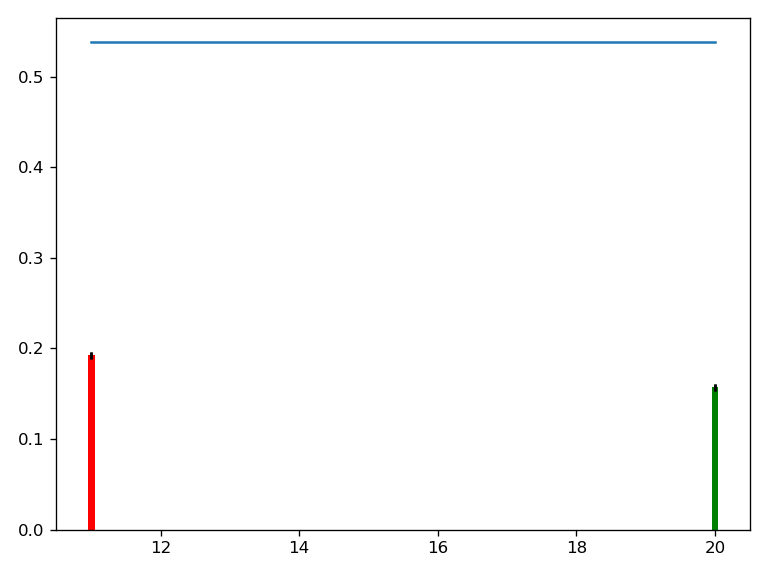

11
(2551, 11)


<IPython.core.display.Javascript object>


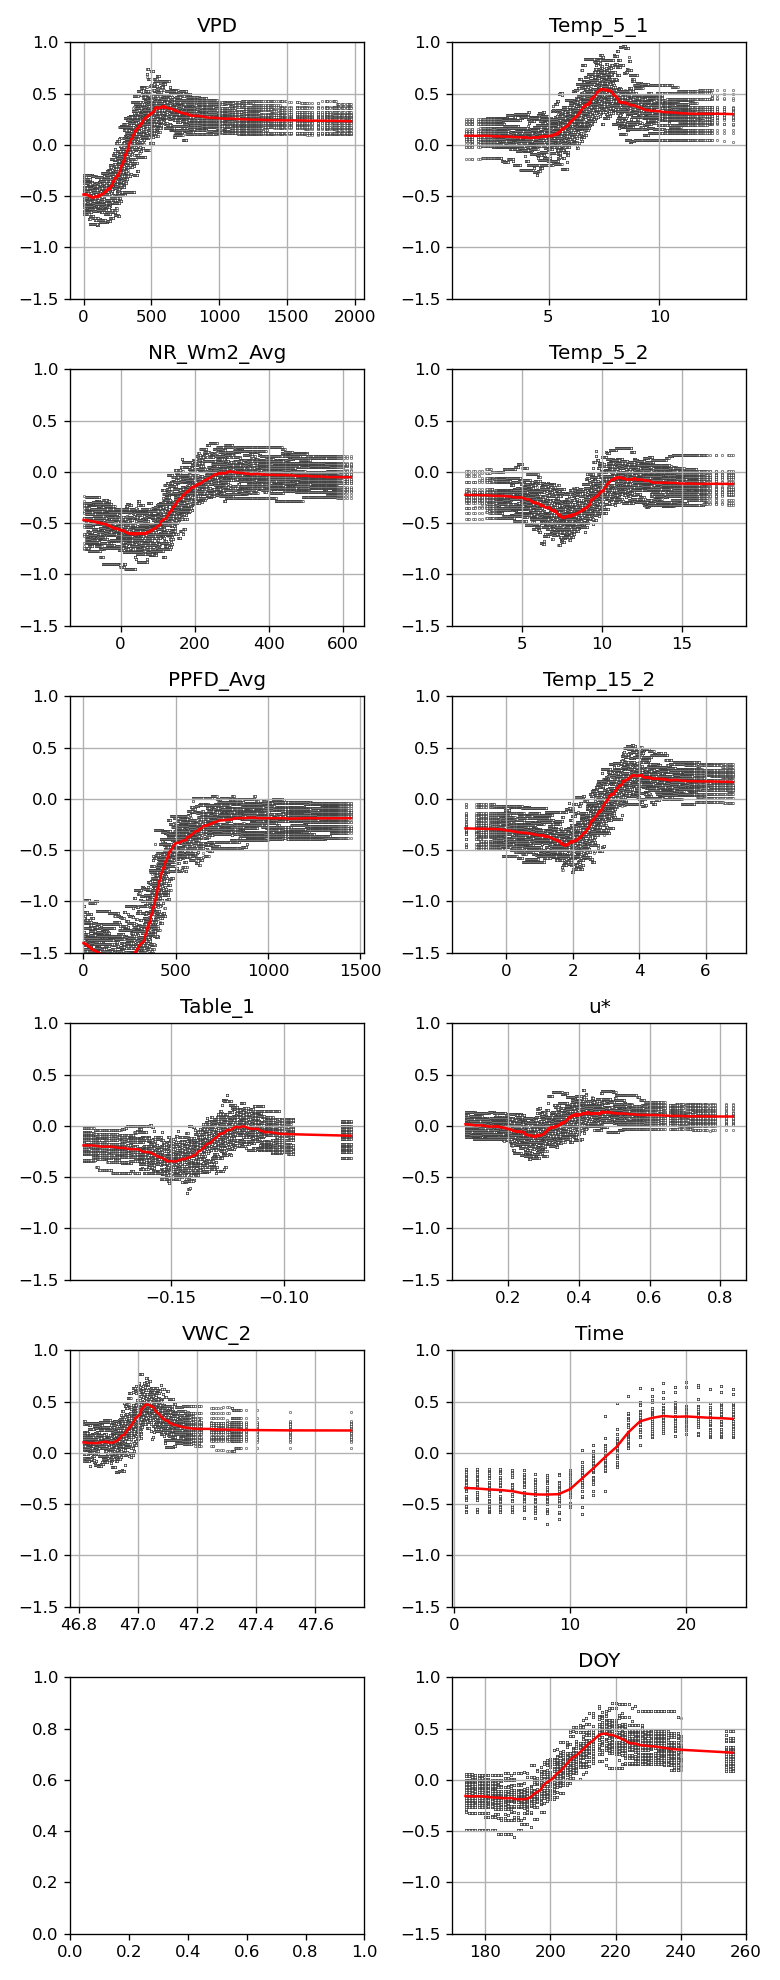

           Factors  RC_Sum: 20_59    RC: 20_59  RG: 20_59  SE: 20_59  \
3         PPFD_Avg       0.423797  2104.816777   0.979581   4.881421   
2       NR_Wm2_Avg       0.107767   535.231179   0.508779   2.530807   
1              VPD       0.049499   245.840056   0.619087   1.978898   
18            Time       0.059197   294.006314   0.721733   2.137990   
9         Temp_5_1       0.035832   177.963038   0.220308   1.900616   
5            VWC_2       0.032265   160.244691   0.200714   1.545508   
12        Temp_5_2       0.036924   183.383659   0.303621   1.809449   
13       Temp_15_2       0.030277   150.373979   0.423710   1.700911   
19             DOY       0.032500   161.411604   0.238896   2.259580   
4          Table_1       0.028668   142.383723   0.109214   1.424452   
7   Active_Layer_1       0.020510   101.864271   0.337241   1.505813   
10       Temp_15_1       0.017265    85.748493   0.303101   1.530630   
11      Temp_2_5_2       0.017124    85.046850   0.166686   1.34

In [202]:
F = 'fco2'
AllRes = RecRead(Path)
print(AllRes.keys())
Results = AllRes[F]['Results']
try:
    Results = Results.drop(columns='Key')
except:
    pass
Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values

SE_Rule = 100

# AllRes[F]['Records']['RMSE']=(AllRes[F]['Records']['MSE']**.5)
Records = AllRes[F]['Records']
print(Records)
# print(Results)

plt.figure()
Min = Records.loc[Records['MSE']==Records['MSE'].min()]
Best = Records.loc[Records['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]*SE_Rule]
Best = Best.loc[Best['Size']==Best['Size'].min()]
Best = Best.loc[Best['Nodes']==Best['Nodes'].min()]
# print(Best)
plt.bar(Records['Size']+Records['Nodes']*0,Records['MSE'],yerr=Records['SE'],width=.1)
plt.bar(Best['Size']+Best['Nodes']*0,Best['MSE'],yerr=Best['SE'],color='r',width=.1)
plt.bar(Min['Size']+Min['Nodes']*0,Min['MSE'],yerr=Min['SE'],color='g',width=.1)
# plt.xticks(Records['Nodes'],Labels,rotation=80)
line = [Min['MSE'].values[0]+Min['SE'].values[0]*SE_Rule,Min['MSE'].values[0]+Min['SE'].values[0]*SE_Rule]
plt.plot([Records['Size'].min(),Records['Size'].max()],line)
# print(Best)
plt.tight_layout()
Size_best = Best.Size.values[0]
Nodes_best = Best.Nodes.values[0]

Size = Size_best
print(Size)
Nodes = Nodes_best

Derivatives = np.load(Path+F+'_Derivatives_'+Best.index.values[0]+'.npy')
Mean = Derivatives.mean(axis=0)
X = np.load(Path+F+'_X_'+str(Size)+'.npy')
print(X.shape)

if Size>2:
    fig,ax = plt.subplots(int((Size+1)/2),2,figsize = (6.5,Size*1.5))
else:
    fig,ax = plt.subplots(2,2,figsize = (6.5,4*1.5))
k = 0
j=0
TD = []
i = 0
mx,mn=-1,1
PD = {}
# plot = 'Table_1'
# a
m = -.495

a = 'RC: '+Best.index.values[0]
ase = 'SE: '+Best.index.values[0]

print(Results.sort_values(by='CS: '+Best.index.values[0]))#[['CS: '+Best.index.values[0],'RC_Sum: '+Best.index.values[0],
#                'Factors']].sort_values(by='RC_Sum: '+Best.index.values[0]))


for f,r in zip(Results.Factors.values,Results[a].values):
#     print()
#     print(f,r)
    if r > 0:
        print(f,i)
#         if f == plot:
        if i >Size/2-1:
            j=1
            k = (math.floor(Size/2))
        for p in range(Derivatives.shape[0]):
            Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Derivatives[p][i].flatten())})#-m)*X[:,i].std()-X[:,i].mean()})
            Temp = Temp.sort_values(by='X')
            ax[i-k,j].scatter(Temp['X'],Temp['Y'],c='white',s=2,edgecolor='k',linewidth=.25)
            if Derivatives[p][i].max()>mx:
                mx=Derivatives[p][i].max()
            if Derivatives[p][i].min()<mn:
                mn=Derivatives[p][i].min()
#         print(Mean[i].shape)
        Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Mean[i].flatten())})#-m)*X[:,i].std()-X[:,i].mean()})
        Temp = Temp.sort_values(by='X')

        ax[i-k,j].plot(Temp['X'],Temp['Y'],color='r')#.scatter(X[:,i],Mean[i],color='k',s=10)
        ax[i-k,j].set_title(f)
        ax[i-k,j].grid()
        ax[i-k,j].set_ylim(-1.5,1)
        TD.append([f,Mean[i].min(),Mean[i].max(),Mean[i].mean(),Mean[i].max()-Mean[i].min(),(Mean[i]**2).sum()])
        i +=1
# print(mn,mx)
# plt.setp(ax, ylim=[mn-m,mx-m])
plt.tight_layout()
Statistics = pd.DataFrame(data=TD,columns=['Factor','Min','Max','Mean','Range','SSQ'])

# print(Statistics.sort_values('Range'))
plt.savefig(F+'Derivs.png')

<IPython.core.display.Javascript object>


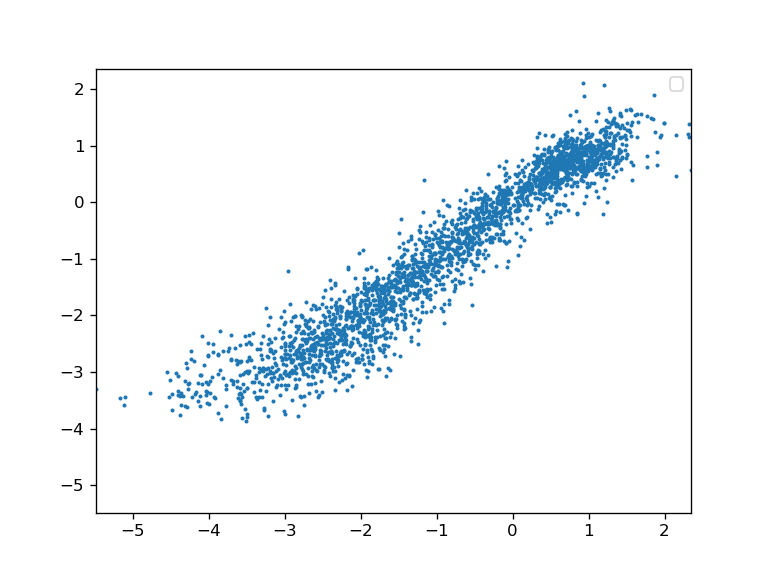

No handles with labels found to put in legend.


0.9011405103325458
0.4385816230622971
0.023451326290960313 5.477225575051661
0.45849538956546904 0.0030122807465341565
0.4385816230622971


In [203]:
RMSE=[]
plt.figure()
y = np.load(Path+F+'_Yhat_'+Best.index.values[0]+'.npy')#.mean(axis=0)
x = np.load(Path+F+'_Ytrue_'+Best.index.values[0]+'.npy')#.mean(axis=0)
for i in range(y.shape[0]):
    df = pd.DataFrame(data={'target':y[i],'y':x[i]}).dropna()
# print(y.shape,x.shape)
#     print(df['y'][0:10])
#     slope,intercept,r,p,SE = stats.linregress(df['y'],df['target'])
# print(Op)
#     plt.scatter(df['y'],df['target'])#(AllRes['fch4'].keys())
    rmse = metrics.mean_squared_error(df['y'],df['target'])**.5
    RMSE.append(rmse)
#     plt.plot(df['y'],intercept+slope*df['y'],label=str(rmse),color='k')
plt.legend()
# plt.xlim(df['y'].min(),df['y'].max())
# plt.ylim(df['y'].min(),df['y'].max())

slope,intercept,r,p,SE = stats.linregress(df['y'],df['target'])
print(r**2)
df = pd.DataFrame(data={'target':np.nanmean(y,axis=0),'y':np.nanmean(x,axis=0)}).dropna()
# print(metrics.r2_score(df['y'],df['target']))
plt.scatter(df['y'],df['target'],s=2)#(AllRes['fch4'].keys())
plt.xlim(df['y'].min(),df['y'].max())
plt.ylim(df['y'].min(),df['y'].max())


print(metrics.mean_squared_error(df['y'],df['target'])**.5)

# df = pd.DataFrame(data={'target':y.mean(axis=0),'y':x.mean(axis=0)}).dropna()
# rmse = metrics.mean_squared_error(df['y'],df['target'])**.5
RMSE = np.array(RMSE)
rmse = RMSE.mean()
SE = ((RMSE-rmse)**2).sum()/(y.shape[0])**.5
print(RMSE.std(),(y.shape[0])**.5)
print(rmse,SE)

print((((df['target']-df['y'])**2).sum()/df['target'].count())**.5)


# # print(((df['target']-df['target'].mean())**2).sum()-)

# X = np.nanmean(x,axis=0)
# Y = np.nanmean(y,axis=0)

# print((((X-X.mean())**2).sum()-((X-np.nanmean(Y))**2).sum())/((X-X.mean())**2).sum())

<IPython.core.display.Javascript object>


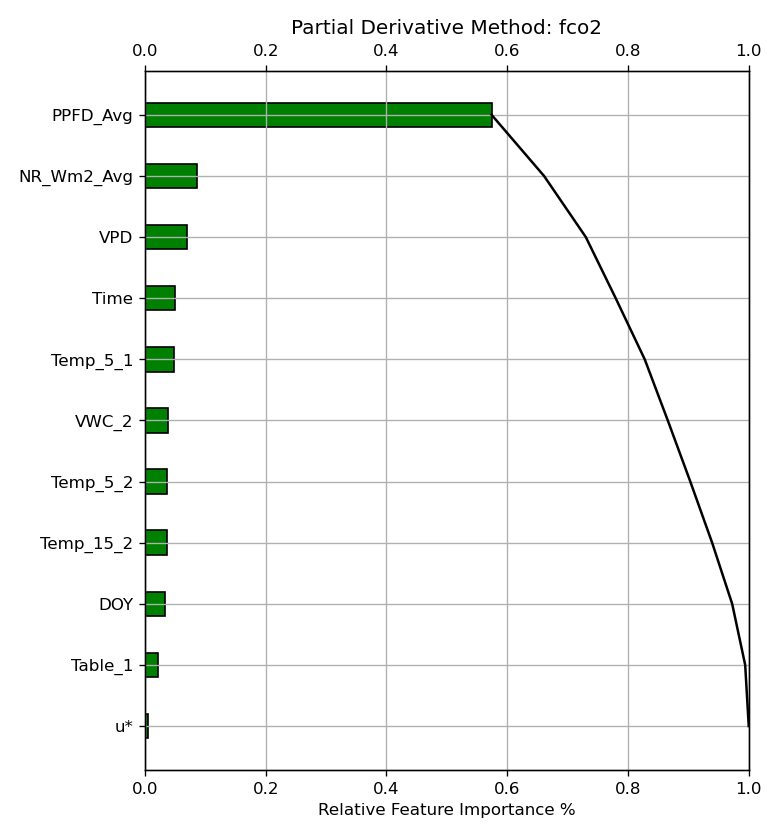

In [204]:


try:
    Results = Results.loc[Results[a]>0].sort_values(a,ascending=True).reset_index()
except:
    pass

# print(a)
# print(Results[a],Results['RC: '+b],)
# print(Results.Factors.values[1:])
# print(Results[a])
fig,ax=plt.subplots(figsize=(6.5,7))
ax.barh(Results.index,Results['RC_Sum: '+Best.index.values[0]],#xerr=Results[ase],
         height=.4,color='g',edgecolor='k')
# ax.barh(Results.index+.45,Results['RC: '+b],xerr=Results['SE: '+b],
#          height=.4,color='r',edgecolor='k')
ax2=ax.twiny()
# Results['Cumsum']=Results[a].sort_values(ascending=False).cumsum().sort_values(ascending=False)
ax2.plot(Results['CS: '+Best.index.values[0]],Results.index,color='k')

# print(Results[['Factors','Cumsum']])
# plt.barh(Results.index+.5,Results['RC: '+Min],xerr=Results['SE: '+Min],height=.5,color='r')
ax.set_yticks(Results.index)
ax.set_yticklabels(Results['Factors'].values)
# plt.xticks(rotation=90)

ax.set_xlabel('Relative Feature Importance %')
ax.set_title('Partial Derivative Method: '+F)
ax.grid()
ax.set_xlim(0,1)
ax2.set_xlim(0,1)
plt.tight_layout()
# plt.show()

plt.savefig('PAD_'+F+'_PrunedFactors.png')
